Analysis of branches
=====================

A transition count matrix is used to run this notebook.

  * [parseIntoBranches.py](parseIntoBranches.py)
  * [pbParser.py](pbParser.py)

The rows are the branches (identified as *child-parent*) and the columns are the transitions

In [43]:
import os,time
import numpy as np
import gensim
from vertebratesLib import *

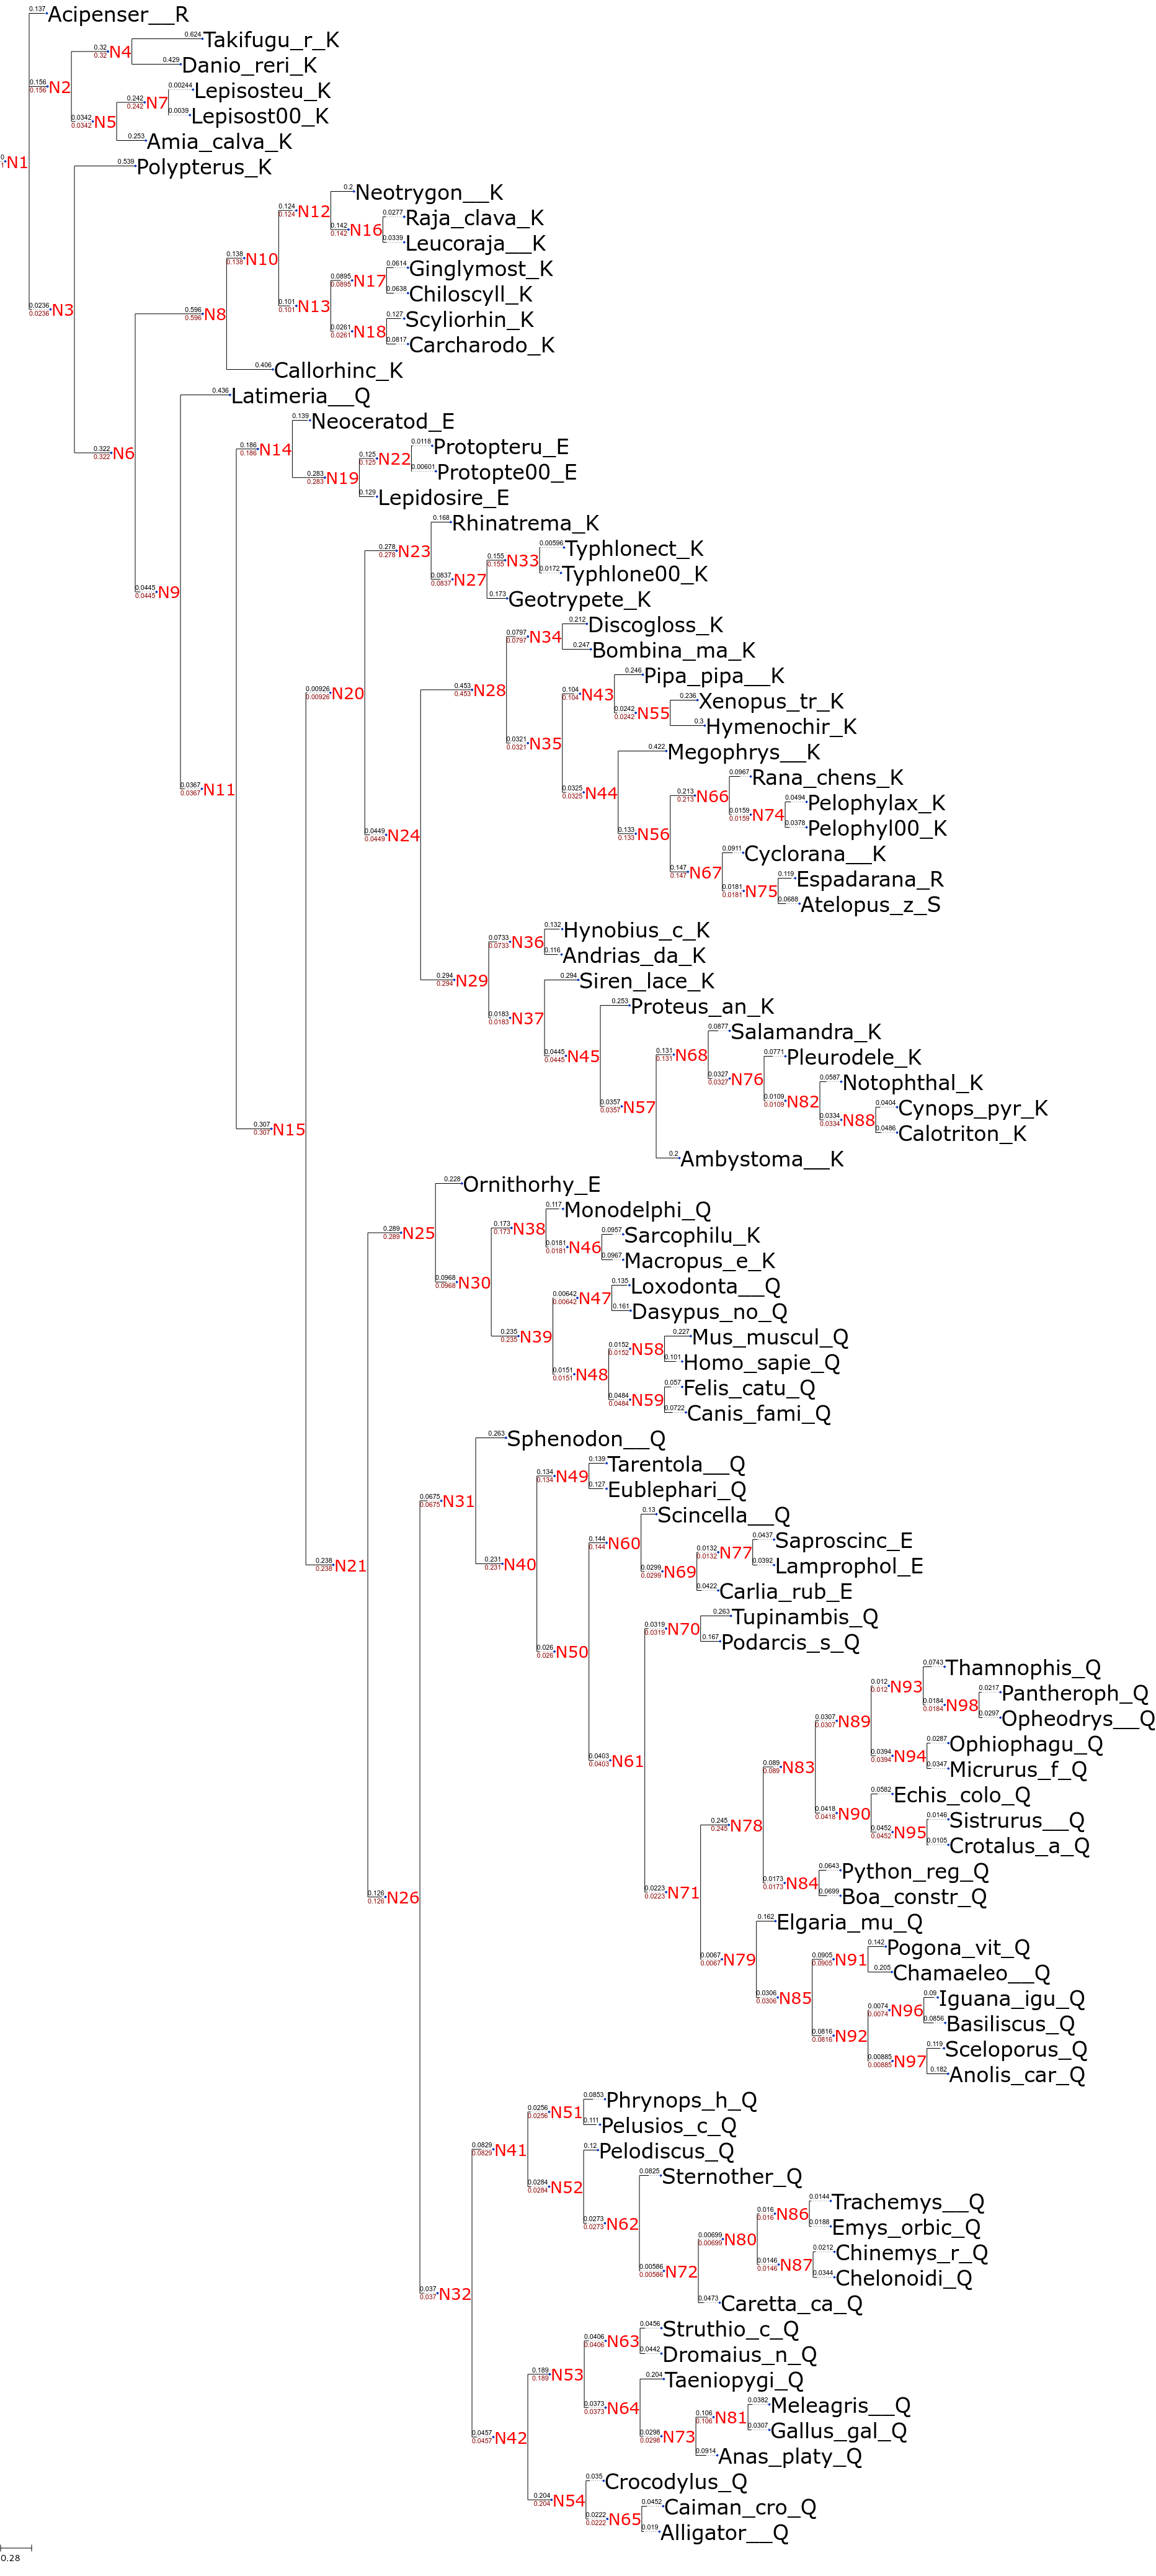

In [44]:
from IPython.display import Image
Image(filename='./figures/simple-tree.png')

Prepare the corpus of documents
----------------------------------------------------------


In [45]:
## make example plots
import matplotlib.pyplot as plt

## load position matrix
mat = None
for split in SPLITS:
    outputFile = os.path.join("..","data","hv-compressed","%s-positions.npz"%(split))
    npz = np.load(outputFile)

    if mat == None:
        mat = npz['tree'].astype(int)
    else:
        mat = np.vstack((mat,npz['tree'].astype(int)))

vocab = npz['columns']

## create the documents from the matrix                                                                                                                                         
texts = []
usedColumns = set([])
usedRows = set([])
for r in range(mat.shape[0]):
    hitInds = np.where(mat[r,:] > 1)[0]
    
    ## ignore inplace transitions and documents with < 2 changes
    hits = vocab[hitInds]
    hits = list(set(hits.tolist()))
    passedHits = []
    for hit in hits:
        if hit[0] == hit[1]:
            continue
        passedHits.append(hit)

    if len(passedHits) < 2:
        continue
        
    usedRows.update([r])
    text = []
    for hi in hitInds:
        word = vocab[hi]

        if word[0] == word[1]:
            continue

        usedColumns.update([hi])
        text.extend([vocab[hi]] * mat[r,hi])
    texts.append(text)
usedColumns = list(usedColumns)
usedRows = list(usedRows)
actualVocab = vocab[usedColumns]
    
dictionary = gensim.corpora.Dictionary(texts)
dictionary.save('/tmp/positions.dict')

## create a corpus from the documents                                                                                                                                                                       
corpus = [dictionary.doc2bow(text) for text in texts]
gensim.corpora.MmCorpus.serialize('/tmp/positions.mm', corpus)
mm = gensim.corpora.MmCorpus('/tmp/positions.mm')
print mm

rowMeans = mat.mean(axis=0)
colMeans = mat.mean(axis=1)
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.hist(rowMeans,bins=50)
ax1.set_title("Transitions")
ax2 = fig.add_subplot(212) 
ax2.hist(colMeans,bins=50)
ax2.set_title("positions")
plt.savefig(os.path.join(".","figures","positions-histograms.png"),dpi=300)

MmCorpus(149102 documents, 372 features, 463257 non-zero entries)


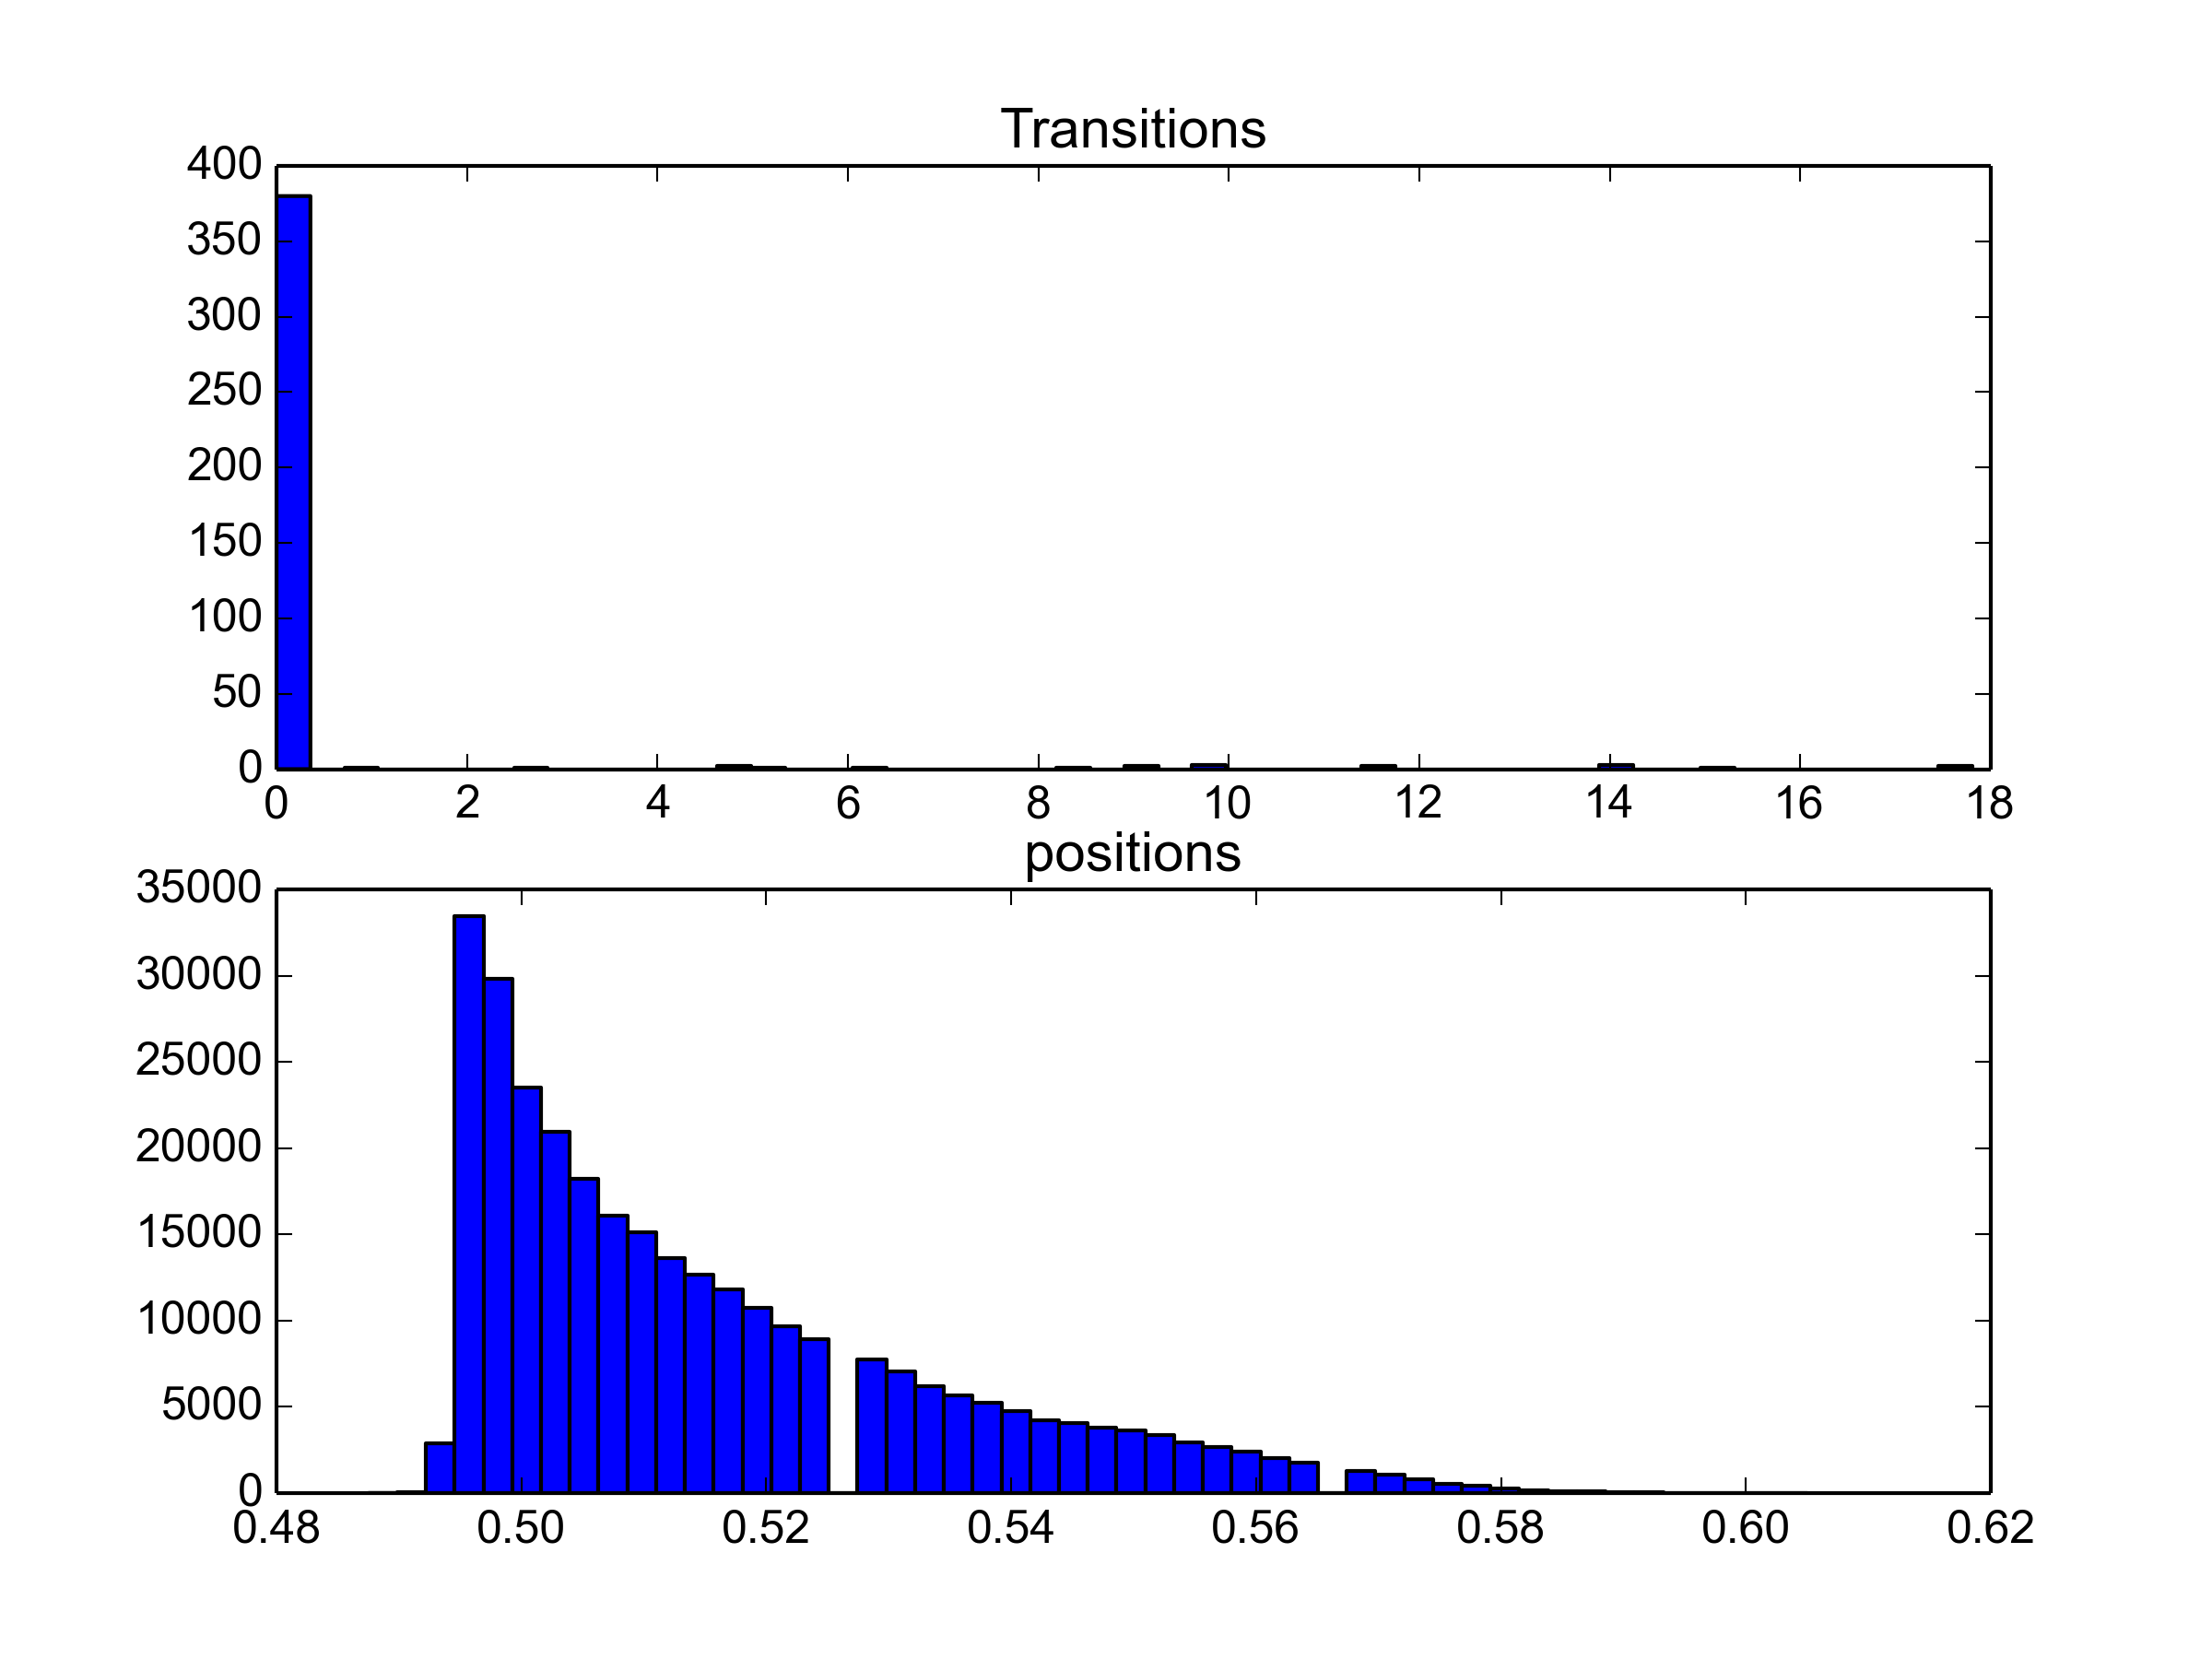

In [46]:
Image(filename=os.path.join(".","figures","positions-histograms.png"))

Run LDA
---------

Run the model

In [47]:
timeStart = time.time()
lda = gensim.models.LdaMulticore(corpus=mm, num_topics=50, id2word=dictionary,chunksize=1000, passes=10)
for t in range(50):
    print("topic-%s: %s"%(t,lda.print_topic(t,topn=8)))
print("end: %s"%time.strftime('%H:%M:%S',time.gmtime(time.time()-timeStart)))

topic-0: 0.244*HY + 0.200*YH + 0.184*CS + 0.127*SC + 0.042*QE + 0.028*CG + 0.016*GC + 0.012*EQ
topic-1: 0.236*SN + 0.130*SR + 0.126*SD + 0.080*SK + 0.064*NS + 0.043*ST + 0.033*TS + 0.032*DS
topic-2: 0.220*NH + 0.196*HN + 0.128*NS + 0.082*ND + 0.048*NE + 0.041*NK + 0.039*SN + 0.022*HS
topic-3: 0.358*DE + 0.210*DN + 0.087*DG + 0.084*ED + 0.063*DS + 0.042*DA + 0.019*QD + 0.018*DH
topic-4: 0.295*RH + 0.276*HR + 0.076*RQ + 0.053*HQ + 0.051*RC + 0.045*CR + 0.016*WR + 0.013*NT
topic-5: 0.425*SP + 0.174*SA + 0.154*ST + 0.043*LH + 0.032*HL + 0.024*SL + 0.010*PS + 0.007*TS
topic-6: 0.217*DE + 0.147*ED + 0.144*IV + 0.059*VI + 0.020*IL + 0.020*PD + 0.017*QE + 0.017*DN
topic-7: 0.172*EV + 0.133*VE + 0.060*ET + 0.058*VG + 0.049*EA + 0.047*WL + 0.046*TE + 0.043*ED
topic-8: 0.214*GE + 0.176*GD + 0.143*EG + 0.063*DG + 0.061*GN + 0.058*AE + 0.044*AD + 0.042*GS
topic-9: 0.296*VM + 0.218*VL + 0.150*VI + 0.044*LV + 0.040*IV + 0.022*IL + 0.021*KR + 0.018*MV
topic-10: 0.382*SG + 0.377*GS + 0.036*AS + 0.026*S

In [49]:

i = 100
actualPosition = usedRows[i]
text = texts[i]
textVector = mm[i]
print len(texts)
print len(mm)

#print("row: %s"%actualPosition)
#print("document: %s"%(text))
#print "vectorized document: ",textVector
for tv in textVector:
    print "...",dictionary[tv[0]]
probDistn = lda[textVector]
print "prob: ", probDistn
print("topics...")
for topic in probDistn:
    print topic[0],round(topic[1],2),
    print lda.print_topic(topic[0], topn=8)


149102
149102
... ED
... DE
... DN
... ND
prob:  [(19, 0.59864912886079169), (49, 0.33277944256778053)]
topics...
19 0.6 0.374*ND + 0.335*DN + 0.029*DE + 0.018*QL + 0.016*PS + 0.012*NS + 0.012*DS + 0.011*SP
49 0.33 0.515*ED + 0.437*DE + 0.007*EQ + 0.007*EK + 0.005*EN + 0.004*QE + 0.003*EA + 0.002*DN
